# Finding Shortest Path
## Using Dijkstra's Algorithm on OpenStreetMap data

OpenStreetMap is a free, open geographic database which allows individuals from around the globe to contribute and edit geographical information.
Google maps uses OSM, however it enriches it with other data, makes it extremely easy to use and makes it proprietary.

In [17]:
import osmnx
import geopandas

place_name = "Rajiv Chowk"

The osmnx python package allows us to retrieve OSM street network data, hence we can type any address from around the world and get a NetworkX MultiDiGraph object with the network.

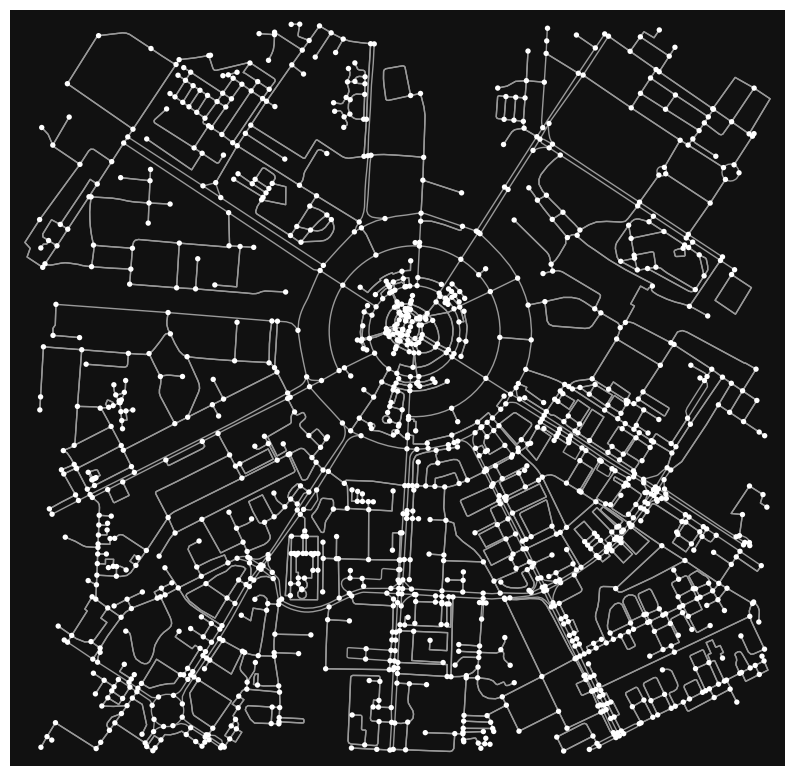

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [3]:
graph = osmnx.graph_from_address(place_name)

osmnx.plot_graph(graph,figsize=(10,10))



In order to get the length between two individual nodes from edge data, the GeoDataframe had to be unpacked. The below cell is a test to check if the expected output is returned.

In [4]:
import pandas as pd

nodes, edges = osmnx.graph_to_gdfs(graph)
#edges = pd.DataFrame(edges)
current_node = 249782331
neighbor = 10239800521
edges = edges[['name', 'length']].reset_index()
print(type(edges))
edges[(edges['u']==current_node) & (edges['v']==neighbor)]['length']

<class 'pandas.core.frame.DataFrame'>


1    120.404
Name: length, dtype: float64

## Dijkstra's Algorithm
Now we write the program for implementation of Dijkstra's algorithm on networkx graphs.

In [5]:
import networkx

def dijkstra(G, source, target):
    nodes, edges = osmnx.graph_to_gdfs(G)
    edges = edges[['name', 'length']].reset_index()
    
    if source == target:
        return (0, [source])

    # Initialise
    dist = {node: float('inf') for node in G.nodes}
    dist[source] = 0
    paths = {node: [] for node in G.nodes}
    paths[source] = [source]
    unvisited_nodes = list(G.nodes)

    while unvisited_nodes:
        current_node = min(unvisited_nodes, key=lambda node: dist[node])
        unvisited_nodes.remove(current_node)
        
        for neighbor, neighbor_data in G[current_node].items():
            edge_weight = edges[(edges['u']==current_node) &
                        (edges['v']==neighbor)].any()['length']
            total_weight = dist[current_node] + edge_weight
            if total_weight < dist[neighbor]:
                dist[neighbor] = total_weight
                paths[neighbor] = paths[current_node] + [neighbor]
    if dist[target] == float('inf'):
        raise nx.NetworkXNoPath(f"No path between {source} and {target}.")
    return dist[target], paths[target]

## Selecting Nodes
For now, we will choose two random nodes from the graph as source and destination. But we can input any coordinate and find the closest nodes to that location in order to calculate the distance.

In [12]:
import random

source_index = random.choice(range(len(nodes)))
destination_index = random.choice(range(len(nodes)))

source_point = (nodes['y'].values[source_index],
                nodes['x'].values[source_index])
destination_point = (nodes['y'].values[destination_index],
                     nodes['x'].values[destination_index])

print(source_point, " ::>> ", destination_point)

(28.6268976, 77.2269996)  ::>>  (28.6276761, 77.2111239)


In [13]:
X = [source_point[1], destination_point[1]]
Y = [source_point[0], destination_point[0]]
closest_nodes = osmnx.distance.nearest_nodes(graph,X,Y)


Nodes can also be selected by entering address names

## Extracting shortest route
Now we will find the distance between the selected nodes using Dijkstra.
Bellman Ford algorithm is used as a comparison.

In [14]:
shortest_route = networkx.shortest_path(G=graph,source=closest_nodes[0],
                target=closest_nodes[1], weight='length', method="bellman-ford")
print("Shortest path by bellman-ford: ", networkx.shortest_path_length(graph,
          source=closest_nodes[0],target=closest_nodes[1], method="bellman-ford"))

dijkstra_route = dijkstra(graph, closest_nodes[0], closest_nodes[1])
print("Shortest path by dijkstra: ", dijkstra_route[0])

Shortest path by bellman-ford:  48
Shortest path by dijkstra:  48


This is what we have now:

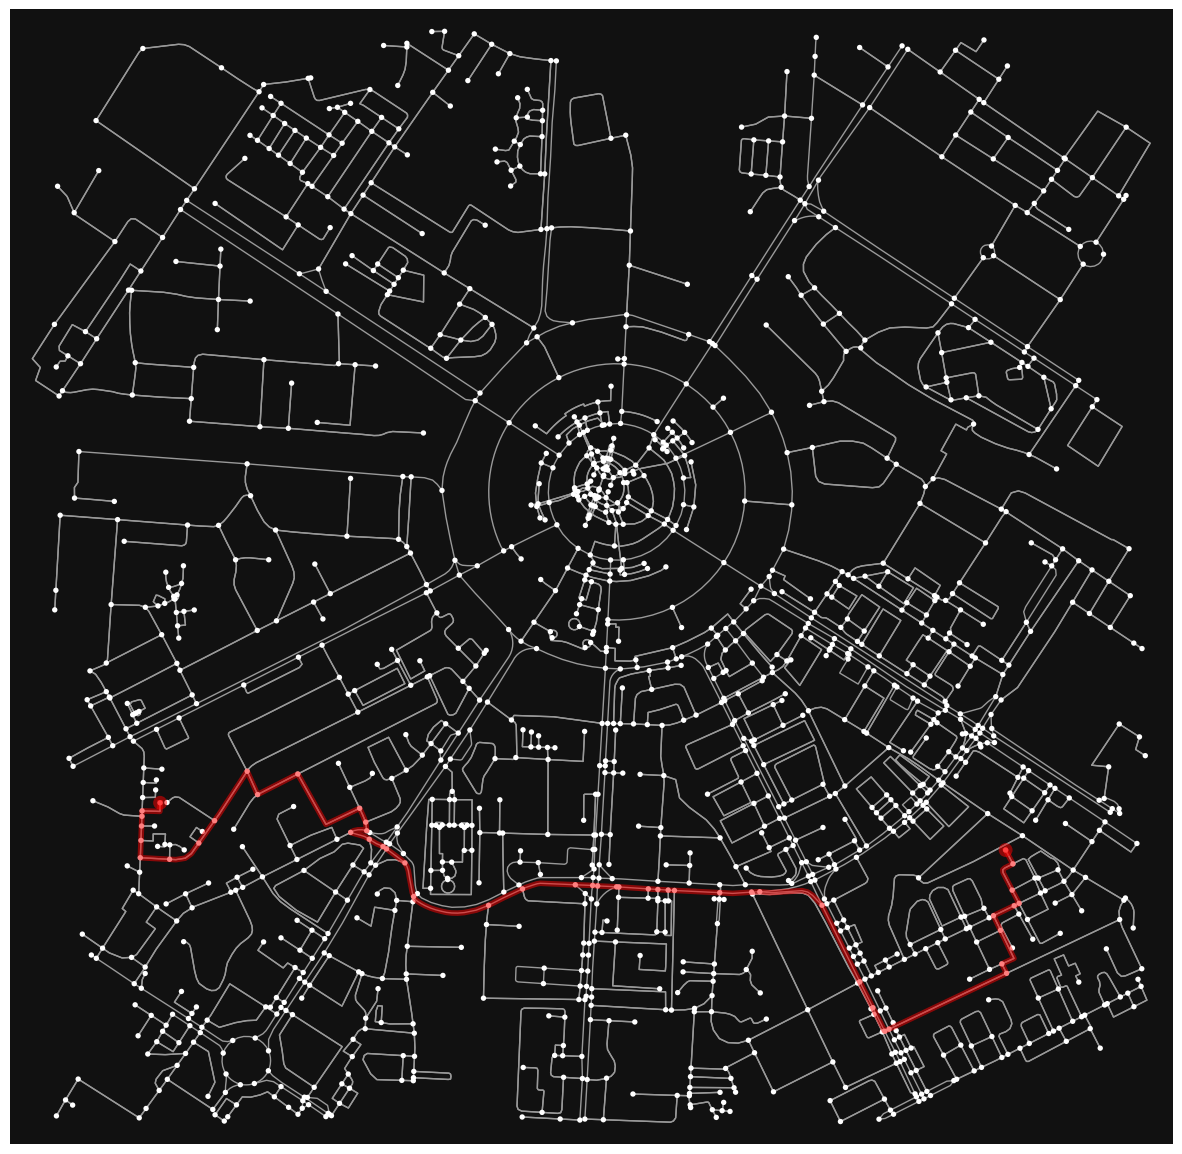

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [15]:
osmnx.plot_graph_route(graph,dijkstra_route[1],figsize=(15,15))

## Visualising the path
We will use folium to visualise the path on an interactive Leaflet map.

In [16]:
import folium
from folium.plugins import FastMarkerCluster

bellman_coordinates = [(graph.nodes[node]['y'], graph.nodes[node]['x'])
                       for node in shortest_route]
dijkstra_coordinates = [(graph.nodes[node]['y'], graph.nodes[node]['x'])
                        for node in dijkstra_route[1]]

map_center = [sum([p[0] for p in bellman_coordinates]) / len(bellman_coordinates),
              sum([p[1] for p in bellman_coordinates]) / len(bellman_coordinates)]

m = folium.Map(location=map_center, zoom_start=12)

FastMarkerCluster(dijkstra_coordinates).add_to(m)
folium.PolyLine(locations=dijkstra_coordinates, color='blue').add_to(m)

m